In [1]:
! pip install timm -q

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore') 

In [4]:
import os
import torch
from fastai import *
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import timm
from timm.models import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import random
import PIL
from timm.data import ImageDataset
from sklearn.metrics import classification_report

In [5]:
#выбор из этих моделей
timm.list_models('*convnext*in22k')

['convnext_base_in22k',
 'convnext_large_in22k',
 'convnext_small_in22k',
 'convnext_tiny_in22k',
 'convnext_xlarge_in22k']

In [6]:
path = Path('../input/clocks-data/my_data')
train = Path(path/'train')
test = Path(path/'test')

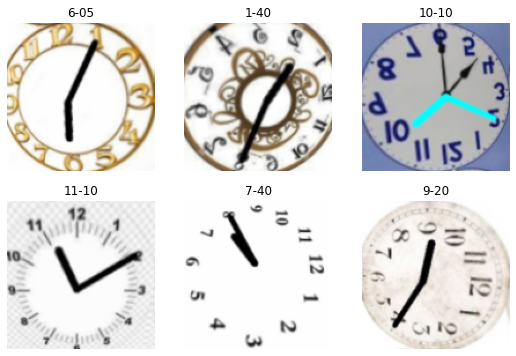

In [7]:
dls = ImageDataLoaders.from_folder(path, train='train', valid='valid', 
                                   seed=42, bs = 64, item_tfms=Resize(128, method='squish'),
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75),
                                   device=torch.device('cuda'))

dls.show_batch(max_n=6)

In [8]:
model_type = 'convnext_xlarge_in22k'
epochs = 40

In [9]:
learn = vision_learner(dls, model_type, model_dir="/kaggle/working/", metrics=error_rate).to_fp16()


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_xlarge_22k_224.pth


SuggestedLRs(valley=0.0014454397605732083)

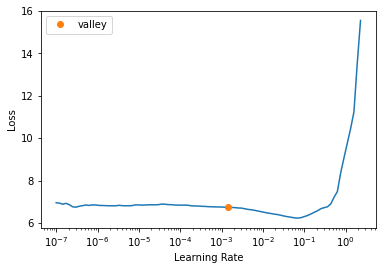

In [10]:
learn.lr_find()

In [11]:
learn.fine_tune(epochs, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,3.990206,2.745009,0.739583,01:34


epoch,train_loss,valid_loss,error_rate,time
0,1.959645,1.379434,0.545139,02:25
1,1.399458,1.162088,0.459722,02:25
2,1.172779,1.072358,0.432639,02:25
3,0.906228,0.833844,0.313889,02:26
4,0.662116,0.574331,0.204861,02:25
5,0.445279,0.395123,0.132639,02:25
6,0.342422,0.328830,0.097222,02:25
7,0.264471,0.274597,0.081250,02:25
8,0.244209,0.272953,0.079861,02:25
9,0.237598,0.219011,0.063194,02:24


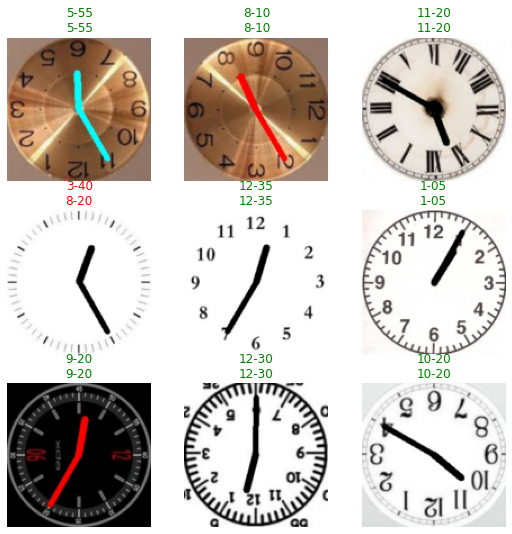

In [12]:
learn.show_results()

In [13]:
def do_test(dls, model_to_test, path):
    my_tst_files = get_image_files(path).sorted()
    my_tst_dl = dls.test_dl(my_tst_files)
    probs,_,idxs = model_to_test.get_preds(dl=my_tst_dl, with_decoded=True)
    mapping = dict(enumerate(dls.vocab))
    reverse_mapping=dict(zip(dls.vocab,list(range(len(dls.vocab)))))
    results = pd.Series(idxs.numpy(),name="idxs").map(mapping)
    testY = []
    for item in my_tst_files:
        testY += [reverse_mapping[item.parent.name]]
    r1 = pd.Series(idxs.numpy(),name="idxs").map(mapping)
    r2 = pd.Series(np.array(testY),name="idxs").map(mapping)
    
    return r1, r2, classification_report(testY, idxs, digits=4)

In [14]:
r1, r2, cr = do_test(dls, learn, test)

In [15]:
print(cr)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         9
           1     1.0000    0.9000    0.9474        10
           2     0.9091    1.0000    0.9524        10
           3     1.0000    1.0000    1.0000        10
           4     0.9000    0.9000    0.9000        10
           5     1.0000    1.0000    1.0000        10
           6     1.0000    1.0000    1.0000        10
           7     1.0000    1.0000    1.0000        10
           8     1.0000    1.0000    1.0000        10
           9     1.0000    1.0000    1.0000        10
          10     1.0000    0.9000    0.9474        10
          11     0.9091    1.0000    0.9524        10
          12     1.0000    1.0000    1.0000        10
          13     1.0000    1.0000    1.0000        10
          14     0.9091    1.0000    0.9524        10
          15     1.0000    1.0000    1.0000        10
          16     1.0000    1.0000    1.0000        10
          17     1.0000    

In [19]:
name = 'epochs_'+ str(epochs) + '_' + model_type

In [20]:
# сохраняем результаты обучения 
learn.save(name)

Path('/kaggle/working/epochs_40_convnext_xlarge_in22k.pth')

In [21]:
from IPython.display import FileLink
FileLink(name + '.pth')

/kaggle/working/epochs_40_convnext_xlarge_in22k.pth